<a href="https://colab.research.google.com/github/shashank-m/humour_detection/blob/master/funny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls /content/gdrive/'My Drive'/'Colab Notebooks'/humour/


funny.ipynb  funny.py  glove.6B.100d.txt  glove.6B.200d.txt  task-1


In [0]:

import pandas as  pd
import numpy as np 
import time

alpha=0
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/humour/task-1/train.csv')
print(df.describe())
start=time.time()
data_list=[]
for row in df.itertuples():
    score=row[-1]
    new_word=row[3]
    original_headline=row[2]
    replaced_word=row[2].split('<')[1].split('>')[0].split('/')[0]
    list_of_words=original_headline.split()
    original_list_of_words=list_of_words
    
    for i,word in enumerate(list_of_words):
        if(word[0]=='<' and word[-1]=='>'):
            alpha=1
            pos_of_replaced_word=i
            break
        if (word[0]=='<'and word[-1]!='>'):
            alpha=-1
            try:
                token=i-1
                pop_1=token+1   
                break
            except:
                # word in beginning
                pop_1=i 
                break
    if alpha==1:
        list_of_words[pos_of_replaced_word]=new_word
    if alpha==-1:
        list_of_words.remove(list_of_words[pop_1])
        list_of_words.remove(list_of_words[pop_1])
        list_of_words.insert(pop_1,new_word)
           
    edited_headline=' '.join(list_of_words)
    
    tup=(replaced_word,original_headline.split(),list_of_words,new_word,score)
    data_list.append(tup)
    
    
        

print('Time taken is {} seconds'.format(time.time()-start))

                 id        grades    meanGrade
count   9652.000000  9.652000e+03  9652.000000
mean    7539.845213  2.048111e+11     0.935571
std     4359.342192  8.211835e+12     0.583643
min        1.000000  0.000000e+00     0.000000
25%     3756.750000  1.110000e+04     0.400000
50%     7510.500000  2.111000e+04     0.800000
75%    11325.250000  3.210000e+04     1.400000
max    15095.000000  3.333332e+14     3.000000
Time taken is 0.06829357147216797 seconds


In [0]:
# encode sentences.

word_embeddings = {}
f = open('/content/gdrive/My Drive/Colab Notebooks/humour/glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    embedding_for_word = np.asarray(values[1:], dtype='float64')
    word_embeddings[word]=embedding_for_word
    


In [0]:
# can use fast Text for encoding.

In [0]:

import math

# data format. replaced_word,original headline list,new headline list,new word.
train=data_list[:math.floor(len(data_list)*0.8)]
test=data_list[math.floor(len(data_list)*0.8):]

def train_test_split(dataset):
  train_sentences=[]

  for data in dataset:
    new_headline=data[2]
    score=data[-1]
    encoded_sentence=[]

    # encode each edited headline
    for word in new_headline:
      try:
        encoded_word=word_embeddings[word]
        encoded_sentence.append(encoded_word)
      except KeyError: # for out of vocabulary words.
        encoded_word=np.random.randn(200)
        encoded_sentence.append(encoded_word)

    train_sentences.append((encoded_sentence,score))   

  df=pd.DataFrame(train_sentences)
  df.columns=['Encoded Sentence','Score']
  X=df['Encoded Sentence']
  Y=df['Score']
  return X,Y
X_train,Y_train=train_test_split(train)
X_test,Y_test=train_test_split(test)



  
 

In [0]:

# pad sequences so that all sentences are of same length to pass into the lstm.
# print(len(train[0][1]))
def padding_zeros(X):
  X_lengths=[ len(sentence) for sentence in X]
  longest=max(X_lengths)
  for i,encoded in enumerate(X):
    length=len(encoded)
    num_zero_arrays=longest-length
    for zeros in range(num_zero_arrays):
      X[i].append(np.zeros(200))
  return X
X_train=padding_zeros(X_train)
X_test=padding_zeros(X_test)



In [0]:


#convert series to array:
def series_to_array(X,Y):
  X_t=[]
  for encoded in X:
    arr=np.asarray(encoded)
  #   arr=np.transpose(arr)
    # arr is the 2d array with shape (max_seq_length,200). Each row is a glove vector of a word.
    X_t.append(arr)

  X_t=np.asarray(X_t)
  Y_t=np.asarray(Y)
  return X_t,Y_t
X_train,Y_train=series_to_array(X_train,Y_train)
X_test,Y_test=series_to_array(X_test,Y_test)

# test_examples=X_test.shape[0]
# X_val=X_test[:int(test_examples/2)]
# Y_val=Y_test[:int(test_examples/2)]

# X_TEST=X_test[int(test_examples/2):]
# Y_TEST=Y_test[int(test_examples/2):]


#X_t has m 200,max_seq_length arrays. where m is number of training examples.


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1)

In [0]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [0]:
#create batches using TensorDataset and Dataloader.
batch_size=64
train_data=TensorDataset(torch.from_numpy(X_train).float(),(torch.from_numpy(Y_train)).float())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)

# val_data=TensorDataset(torch.from_numpy(X_val).float(),(torch.from_numpy(Y_val)).float())
# val_loader=DataLoader(val_data,batch_size=batch_size,shuffle=True,drop_last=True)

test_data=TensorDataset(torch.from_numpy(X_test).float(),(torch.from_numpy(Y_test)).float())
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=True,drop_last=True)

data_iter=iter(train_loader)
sample_x,sample_y=data_iter.next()
print(sample_x[31])
print(sample_y.type())
# print(int(X_trai

tensor([[ 1.5817,  1.2859, -0.7280,  ..., -0.9252,  0.5121, -0.1103],
        [-1.5280, -1.2662,  0.5615,  ..., -1.8247, -1.1812,  0.2123],
        [ 0.3769, -0.1656, -1.4470,  ..., -1.7291,  0.8613,  0.4487],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
torch.FloatTensor


In [0]:

# build lstm.
class humour_model(nn.Module):
  
  
  def __init__(self,input_dim,hidden_dim,n_layers,drop_prob=0.2):
    super(humour_model, self).__init__()
    self.input_dim=input_dim
    self.hidden_dim=hidden_dim
    self.n_layers=n_layers
    
    
    # lstm layer.
    self.lstm=nn.LSTM(self.input_dim,hidden_dim,n_layers,dropout=drop_prob,batch_first=True,bidirectional=True)
    
    # define a droput layer between fc layer and lstm output.
    self.dropout=nn.Dropout(drop_prob)
    
    # final output/ final hidden state(hidden_state[0]) is passed through a fc layer to get desired output.
    self.feed_forward=nn.Sequential(nn.Linear(hidden_dim,50),nn.ReLU(),self.dropout,nn.Linear(50,1),nn.Sigmoid())
    
    
  def forward(self,x,hidden):

    out,hidden=self.lstm(x,hidden)

    # pass only final hidden state to feedforward network.
    final_hidden=hidden[0][self.n_layers*2 - 1]
    
    
    
    output=self.feed_forward(final_hidden)
      
    return output*3

  def init_hidden(self, batch_size):
      ''' Initializes hidden state '''
      # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
      # initialized to zero, for hidden state and cell state of LSTM
      weight = next(self.parameters()).data

      if (is_cuda):
          hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda(),
                weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda())
      else:
          hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_(),
                    weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_())

      return hidden

      

  
  
  
  

In [0]:

# instanstiate model
hidden_dim=100
input_dim=X_train.shape[2]
n_layers=2
model=humour_model(input_dim,hidden_dim,n_layers)    
print(next(model.parameters()))

Parameter containing:
tensor([[-0.0591, -0.0296,  0.0201,  ..., -0.0235,  0.0477, -0.0569],
        [ 0.0025, -0.0044, -0.0621,  ...,  0.0720, -0.0111,  0.0496],
        [ 0.0342, -0.0902,  0.0397,  ...,  0.0481,  0.0512,  0.0317],
        ...,
        [-0.0377,  0.0883,  0.0945,  ...,  0.0949,  0.0474, -0.0789],
        [ 0.0130, -0.0261,  0.0842,  ..., -0.0679, -0.0930, -0.0572],
        [-0.0513, -0.0912,  0.0200,  ...,  0.0429, -0.0256,  0.0332]],
       requires_grad=True)


In [0]:


lr=0.00001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Epoch: 1/20... Step: 100... Loss: 0.871665... Val Loss: 0.842924
Epoch: 2/20... Step: 200... Loss: 0.964351... Val Loss: 0.829799
Epoch: 3/20... Step: 300... Loss: 0.781885... Val Loss: 0.814991
Epoch: 4/20... Step: 400... Loss: 0.754069... Val Loss: 0.785963
Epoch: 5/20... Step: 500... Loss: 0.642487... Val Loss: 0.717744
Epoch: 5/20... Step: 600... Loss: 0.593968... Val Loss: 0.632630
Epoch: 6/20... Step: 700... Loss: 0.611486... Val Loss: 0.611621
Epoch: 7/20... Step: 800... Loss: 0.624541... Val Loss: 0.606848
Epoch: 8/20... Step: 900... Loss: 0.563420... Val Loss: 0.605429
Epoch: 9/20... Step: 1000... Loss: 0.579767... Val Loss: 0.601528
Epoch: 10/20... Step: 1100... Loss: 0.560410... Val Loss: 0.601102
Epoch: 10/20... Step: 1200... Loss: 0.601617... Val Loss: 0.600065
Epoch: 11/20... Step: 1300... Loss: 0.646178... Val Loss: 0.597358
Epoch: 12/20... Step: 1400... Loss: 0.600130... Val Loss: 0.595389
Epoch: 13/20... Step: 1500... Loss: 0.524764... Val Loss: 0.596783
Epoch: 14/20..

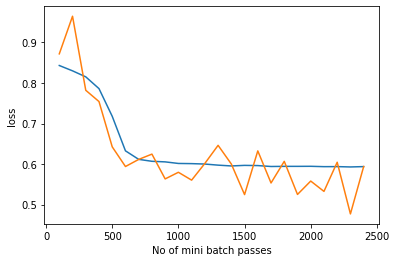

In [0]:

# training loop.
import matplotlib.pyplot as plt
epochs = 20
counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(is_cuda):
    model.cuda()

model.train()
x=[]
y=[]
y_train=[]
for i in range(epochs):
  h = model.init_hidden(batch_size)
  
  # train_losses=[]
  for inputs, labels in train_loader:
      counter += 1

      if(is_cuda):
          inputs, labels = inputs.cuda(), labels.cuda()

      # Creating new variables for the hidden state, otherwise
      # we'd backprop through the entire training history
      h = tuple([each.data for each in h])
      model.zero_grad()

      # get the output from the model
      output=model.forward(inputs,h)
    
      # calculate the loss and perform backprop
      loss = torch.sqrt(criterion(output.squeeze(), labels))
      loss.backward()
      # train_losses.append(loss.item())

      # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
      nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step()              
  
  # loss stats
      if counter % print_every == 0:
          # Get validation loss
          x.append(counter)
          val_h = model.init_hidden(batch_size)
          val_losses = []
          model.eval() # putting model to test mode. 
          for inputs, labels in test_loader:

              val_h = tuple([each.data for each in val_h])

              if(is_cuda):
                  inputs, labels = inputs.cuda(), labels.cuda()

              output=model.forward(inputs,h)
              
              val_loss = torch.sqrt(criterion(output.squeeze(), labels))

              val_losses.append(val_loss.item())

          model.train() # bring model back to training mode. 
          print("Epoch: {}/{}...".format(i+1, epochs),
                "Step: {}...".format(counter),
                "Loss: {:.6f}...".format(loss.item()),
                "Val Loss: {:.6f}".format(np.mean(val_losses)))
          
          y.append(np.mean(val_losses))
          y_train.append(loss.item())
          # train_losses=[]
plt.plot(x,y)
plt.plot(x,y_train)
plt.xlabel('No of mini batch passes')
plt.ylabel('loss')
plt.show()

# plt.xlabel('No of mini batch passes')
# plt.ylabel('Train loss')
# plt.show()
      